In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange 
import xarray as xr
import scipy.io as sio
import datetime as dt
import pyspectral.blackbody

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Download GOES ABI-L1b-RadC band 14 imagery for for Feb 1-15 2020, and create timeseries files for the two Grand Mesa SnowEx 2020 field locations, using the goes-ortho library and command line utilities.

**Download imagery:**

Longwave window (11.2 micron):
* GOES-16 Band 14 (TIR):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C14 -b 30 50 -125 -105 -d /storage/GOES`
* GOES-17 Band 14 (TIR):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C14 -b 30 50 -125 -105 -d /storage/GOES`
  
Shortwave window (3.9 micron):
* GOES-16 Band 7 (MWIR):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C07 -b 30 50 -125 -105 -d /storage/GOES`
* GOES-17 Band 7 (MWIR):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C07 -b 30 50 -125 -105 -d /storage/GOES`
  
Visible (red, 0.64 micron):
* GOES-16 Band 2 for a 1x1 degree area (visible, red):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 7 12 -p ABI-L1b-RadC -c C02 -b 39.5 38.5 -108.5 -107.5 -d /storage/GOES`
* GOES-17 Band 2 for a 1x1 degree area (visible, red):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 7 12 -p ABI-L1b-RadC -c C02 -b 39.5 38.5 -108.5 -107.5 -d /storage/GOES`

**Create timeseries files:**
* Grand Mesa West:
  * Create GOES-16 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/02 -l 39.0339 -108.2140 3033`
      * *GrandMesaWest_GOES-16_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * ...
      * ...
  * Create GOES-17 timeseries:
    * Langwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/02 -l 39.0339 -108.2140 3033`
      * ...
    * Shortwave Window:
      * ...
      * ...
* Snow Pit 2S10:
  * Create GOES-16 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/02 -l 39.0195 -108.1923 3043`
      * *SnowPit2S10_GOES-16_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/2 -c C07 -l 39.0195 -108.1923 3043 -o SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl`
      * *SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl*
  * Create GOES-17 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/2 -l 39.0195 -108.1923 3043`
      * *SnowPit2S10_GOES-17_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/2 -c C07 -l 39.0195 -108.1923 3043 -o SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl`
      * *SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl*

In [3]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    # From: https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

Read in the data file:

In [4]:
# Set column headers:
headers_gm1 = ['table', 'year', 'doy', 'time',
               'rad_avg', 'rad_max', 'rad_min', 'rad_std',
               'sb_avg', 'sb_max', 'sb_min', 'sb_std',
               'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std',
               'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std',
               'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std',
               'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std',
               'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std',
               'batt','b',]

# Open ground data from GM1 site:
gm1 = pd.read_csv('data/CR10X_GM1_final_storage_1.dat',
                 header = None, names = headers_gm1)

Perform some formatting and cleanup:

In [5]:
# Pad zeros to time strings
gm1['time_str'] = [('0' * (4 - len(str(gm1.time[i])))) + str(gm1.time[i]) for i in range(gm1.shape[0])]

for i in range(gm1.shape[0]):
    if gm1.time_str[i] == '2400':
        gm1.time_str[i] = '0000'
        gm1.doy[i] = gm1.doy[i] + 1
        
# Convert year and day of year to pandas datetime index:
gm1['date'] = compose_date(gm1['year'], days=gm1['doy'])
gm1.index = [pd.to_datetime(str(gm1.date[i])[:-9] + 'T' + str(gm1.time_str[i])) for i in range(gm1.shape[0])]

# Get table 102 entires, battery info
gm1_102 = gm1[gm1.table == 102]

# Remove entries that are part of "Table 102"
gm1 = gm1[gm1.table != 102]

# Remove dates before observation periods (Feb 5th for GM1)
gm1 = gm1[gm1.index >= pd.datetime(2020,2,5,11,0)]

C:\Users\steve\AppData\Local\Temp\ipykernel_6880\2220148640.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm1.time_str[i] = '0000'
C:\Users\steve\AppData\Local\Temp\ipykernel_6880\2220148640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm1.doy[i] = gm1.doy[i] + 1
C:\Users\steve\AppData\Local\Temp\ipykernel_6880\2220148640.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  gm1 = gm1[gm1.index >= pd.datetime(2020,2,5,11,0)]


Inspect the data series:

In [6]:
gm1.tail()

,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt,b,time_str,date
2020-02-12 15:10:00,101,2020,43,1510,-9.3700,-9.0437,-9.7752,0.184,-5.9076,-5.8069,...,-7.3058,0.009,-6.1055,-6.1015,-6.1066,0.002,NaN,NaN,1510,2020-02-12
2020-02-12 15:15:00,101,2020,43,1515,-8.9315,-8.4953,-9.5780,0.336,-6.0095,-5.9826,...,-7.2757,0.013,-6.0973,-6.0916,-6.1065,0.005,NaN,NaN,1515,2020-02-12
2020-02-12 15:20:00,101,2020,43,1520,-10.1200,-9.7869,-10.4040,0.215,-6.4162,-6.0925,...,-7.2557,0.009,-6.1010,-6.0916,-6.1064,0.004,NaN,NaN,1520,2020-02-12
2020-02-12 15:25:00,101,2020,43,1525,-9.5534,-9.2206,-9.9084,0.236,-6.7033,-6.6493,...,-7.2357,0.013,-6.0921,-6.0867,-6.1015,0.005,NaN,NaN,1525,2020-02-12
2020-02-12 15:30:00,101,2020,43,1530,-9.6601,-8.9519,-10.7450,0.551,-6.6635,-6.5886,...,-7.1959,0.005,-6.0883,-6.0868,-6.0918,0.002,NaN,NaN,1530,2020-02-12


Plot:

---

Read in VIIRS LST

In [7]:
viirs_day = pd.read_csv('data\VIIRS\snowpit2s10_viirs_day\SnowPit2S10-VIIRS-Day-VNP21A1D-001-results.csv')
viirs_night = pd.read_csv('data\VIIRS\snowpit2s10_viirs_night\SnowPit2S10-VIIRS-Night-VNP21A1N-001-results.csv')

In [8]:
# Combine date and time into a timestamp
viirs_day['viirs_day_timestamps'] = [pd.Timestamp(date) + pd.to_timedelta(hours, unit='h') for date, hours in np.array([viirs_day.Date.values, viirs_day.VNP21A1D_001_View_Time.values]).T]
viirs_night['viirs_night_timestamps'] = [pd.Timestamp(date) + pd.to_timedelta(hours, unit='h') for date, hours in np.array([viirs_night.Date.values, viirs_night.VNP21A1N_001_View_Time.values]).T]

# replace 0 values with NaN
viirs_day.VNP21A1D_001_LST_1KM.replace(0, np.NaN, inplace=True)
viirs_night.VNP21A1N_001_LST_1KM.replace(0, np.NaN, inplace=True)

# create an LST column in degrees C
viirs_day['LST_C'] = viirs_day.VNP21A1D_001_LST_1KM - 273.15
viirs_night['LST_C'] = viirs_night.VNP21A1N_001_LST_1KM - 273.15

<AxesSubplot:xlabel='viirs_night_timestamps'>

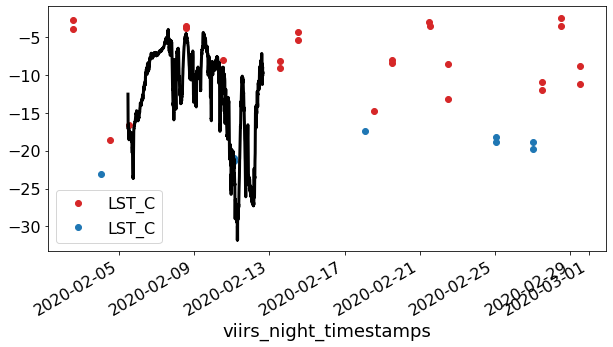

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
viirs_day.plot(x='viirs_day_timestamps', y='LST_C', linestyle='none', marker='o', color='tab:red', ax=ax)
viirs_night.plot(x='viirs_night_timestamps', y='LST_C', linestyle='none', marker='o', color='tab:blue', ax=ax)
gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=3, c='k', label='Surface', zorder=99)

---
Read in MODIS LST

In [10]:
modis_aqua = pd.read_csv('data\MODIS\snowpit2s10_modis_aqua\SnowPit2S10-MODIS-Aqua-MYD11A1-006-results.csv')
modis_terra = pd.read_csv('data\MODIS\snowpit2s10_modis_terra\SnowPit2S10-MODIS-Terra-MOD11A1-006-results.csv')

In [11]:
# Ignore any rows with MxD11A1_006_Day/Night_view_time == 255
modis_aqua = modis_aqua[~(modis_aqua.MYD11A1_006_Day_view_time == 255)]
modis_aqua = modis_aqua[~(modis_aqua.MYD11A1_006_Night_view_time == 255)]
modis_terra = modis_terra[~(modis_terra.MOD11A1_006_Day_view_time == 255)]
modis_terra = modis_terra[~(modis_terra.MOD11A1_006_Night_view_time == 255)]

# Combine date and time into a timestamp
modis_aqua['modis_aqua_day_timestamps'] = [pd.Timestamp(date) + pd.to_timedelta(hours, unit='h') for date, hours in np.array([modis_aqua.Date.values, modis_aqua.MYD11A1_006_Day_view_time.values]).T]
modis_aqua['modis_aqua_night_timestamps'] = [pd.Timestamp(date) + pd.to_timedelta(hours, unit='h') for date, hours in np.array([modis_aqua.Date.values, modis_aqua.MYD11A1_006_Night_view_time.values]).T]
modis_terra['modis_terra_day_timestamps'] = [pd.Timestamp(date) + pd.to_timedelta(hours, unit='h') for date, hours in np.array([modis_terra.Date.values, modis_terra.MOD11A1_006_Day_view_time.values]).T]
modis_terra['modis_terra_night_timestamps'] = [pd.Timestamp(date) + pd.to_timedelta(hours, unit='h') for date, hours in np.array([modis_terra.Date.values, modis_terra.MOD11A1_006_Night_view_time.values]).T]

In [12]:
modis_aqua['LST_Day_C'] = modis_aqua.MYD11A1_006_LST_Day_1km - 273.15
modis_aqua['LST_Night_C'] = modis_aqua.MYD11A1_006_LST_Night_1km - 273.15

modis_terra['LST_Day_C'] = modis_terra.MOD11A1_006_LST_Day_1km - 273.15
modis_terra['LST_Night_C'] = modis_terra.MOD11A1_006_LST_Night_1km - 273.15

<AxesSubplot:xlabel='modis_terra_night_timestamps'>

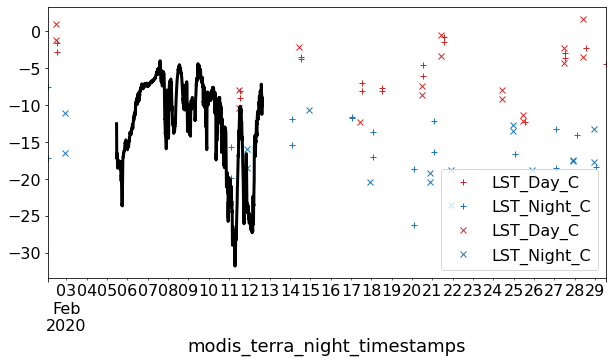

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=3, c='k', label='Surface', zorder=99)

modis_aqua.plot(x='modis_aqua_day_timestamps', y='LST_Day_C', linestyle='none', marker='+', color='tab:red', ax=ax)
modis_aqua.plot(x='modis_aqua_night_timestamps', y='LST_Night_C', linestyle='none', marker='+', color='tab:blue', ax=ax)

modis_terra.plot(x='modis_terra_day_timestamps', y='LST_Day_C', linestyle='none', marker='x', color='tab:red', ax=ax)
modis_terra.plot(x='modis_terra_night_timestamps', y='LST_Night_C', linestyle='none', marker='x', color='tab:blue', ax=ax)

---

Read in GOES ABI, Band 14 brightness temperature timeseries:

In [14]:
# Read files
g16_c14 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-16_timeseries_Feb2020.pkl')
g17_c14 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-17_C14_timeseries_Feb2020.pkl')

# Convert UTC to UTC-7 (MST) and set index to the datetime
g16_c14.index  = pd.to_datetime(g16_c14.time) - pd.Timedelta(hours=7)
g17_c14.index  = pd.to_datetime(g17_c14.time) - pd.Timedelta(hours=7)

Read in GOES ABI, Band 14 brightness temperature timeseries:

In [15]:
# Read files
g16_c7 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl')
g17_c7 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl')

# Convert UTC to UTC-7 (MST) and set index to the datetime
g16_c7.index  = pd.to_datetime(g16_c7.time) - pd.Timedelta(hours=7)
g17_c7.index  = pd.to_datetime(g17_c7.time) - pd.Timedelta(hours=7)

---

# Get snowpit temperature data

From csv file created in airborne_vs_snowpits.ipynb

In [22]:
df_tss = pd.read_csv('snowex2020_snowpit_surface_temperatures.csv')

In [23]:
df_tss['time'] = pd.to_datetime(df_tss.time)

df_tss.set_index('time', inplace=True)

C:\Users\steve\AppData\Local\Temp\ipykernel_6880\3815128746.py:4: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  df_tss.resample('6H', loffset='3H').mean().temperature.plot(linestyle='none', marker='D', markersize=7, color='k', ax=ax, label='6-hour mean snow pit surface temperature')


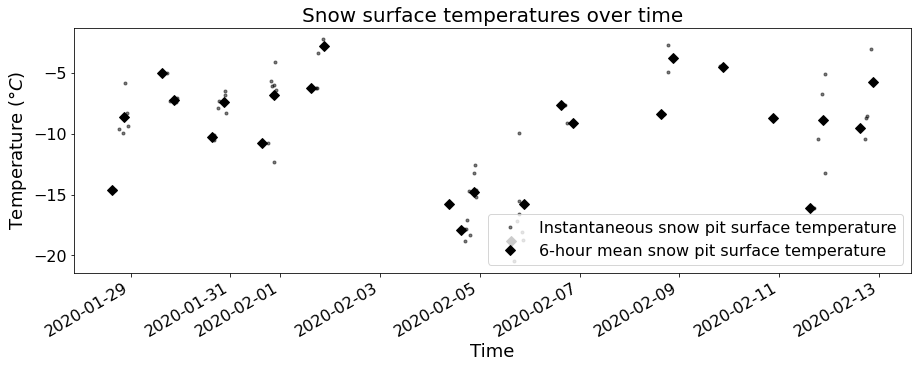

In [27]:
fig, ax = plt.subplots(figsize=(15,5))

df_tss.temperature.plot(linestyle='none',marker='.', color='k', alpha=0.5, ax=ax, label='Instantaneous snow pit surface temperature')
df_tss.resample('6H', loffset='3H').mean().temperature.plot(linestyle='none', marker='D', markersize=7, color='k', ax=ax, label='6-hour mean snow pit surface temperature')


ax.set_xlabel('Time')
ax.set_ylabel('Temperature ($\degree C$)')
ax.set_title('Snow surface temperatures over time')
plt.legend(loc='lower right')


---
### Plot all together:

Read all the datetimes we have for aircraft IR

In [29]:
files = [r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb08_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb10_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb12_mosaicked.mat'
        ]
datetimes = []
for file in files:
    aircraft_data_mat = sio.loadmat(file)
    for i in range(aircraft_data_mat['time'][0,:].shape[0]):
        matlab_datenum = aircraft_data_mat['time'][0,i]
        python_datetime = pd.datetime.fromtimestamp(matlab_datenum)
        datetimes.append(python_datetime)

datetimes

C:\Users\steve\AppData\Local\Temp\ipykernel_6880\60693244.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  python_datetime = pd.datetime.fromtimestamp(matlab_datenum)


[datetime.datetime(2020, 2, 8, 7, 7, 17, 946189),
 datetime.datetime(2020, 2, 8, 7, 16, 44, 712175),
 datetime.datetime(2020, 2, 8, 7, 28, 32, 337137),
 datetime.datetime(2020, 2, 8, 7, 43, 2, 133228),
 datetime.datetime(2020, 2, 8, 7, 55, 59, 22164),
 datetime.datetime(2020, 2, 8, 8, 7, 54, 639167),
 datetime.datetime(2020, 2, 8, 10, 7, 37, 808115),
 datetime.datetime(2020, 2, 8, 10, 19, 15, 110315),
 datetime.datetime(2020, 2, 8, 10, 29, 16, 175215),
 datetime.datetime(2020, 2, 8, 10, 40, 56, 807211),
 datetime.datetime(2020, 2, 8, 10, 50, 20, 909175),
 datetime.datetime(2020, 2, 8, 11, 1, 9, 260000),
 datetime.datetime(2020, 2, 8, 11, 6, 22, 280167),
 datetime.datetime(2020, 2, 8, 11, 18, 49, 199265),
 datetime.datetime(2020, 2, 8, 11, 31, 35, 765195),
 datetime.datetime(2020, 2, 8, 11, 44, 28, 325184),
 datetime.datetime(2020, 2, 8, 11, 56, 16, 283170),
 datetime.datetime(2020, 2, 10, 14, 52, 32, 360940),
 datetime.datetime(2020, 2, 10, 15, 4, 31, 974179),
 datetime.datetime(2020, 

C:\Users\steve\AppData\Local\Temp\ipykernel_6880\2242466026.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  startdate = pd.datetime(2020,2,5,11,0)
C:\Users\steve\AppData\Local\Temp\ipykernel_6880\2242466026.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  enddate = pd.datetime(2020,2,12,16,0)
C:\Users\steve\AppData\Local\Temp\ipykernel_6880\2242466026.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.plot(pd.datetime(2020,2,8,11,7),-5.8,'D',c=ast_color,markersize=10, zorder=99)
C:\Users\steve\AppData\Local\Temp\ipykernel_6880\2242466026.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime modul

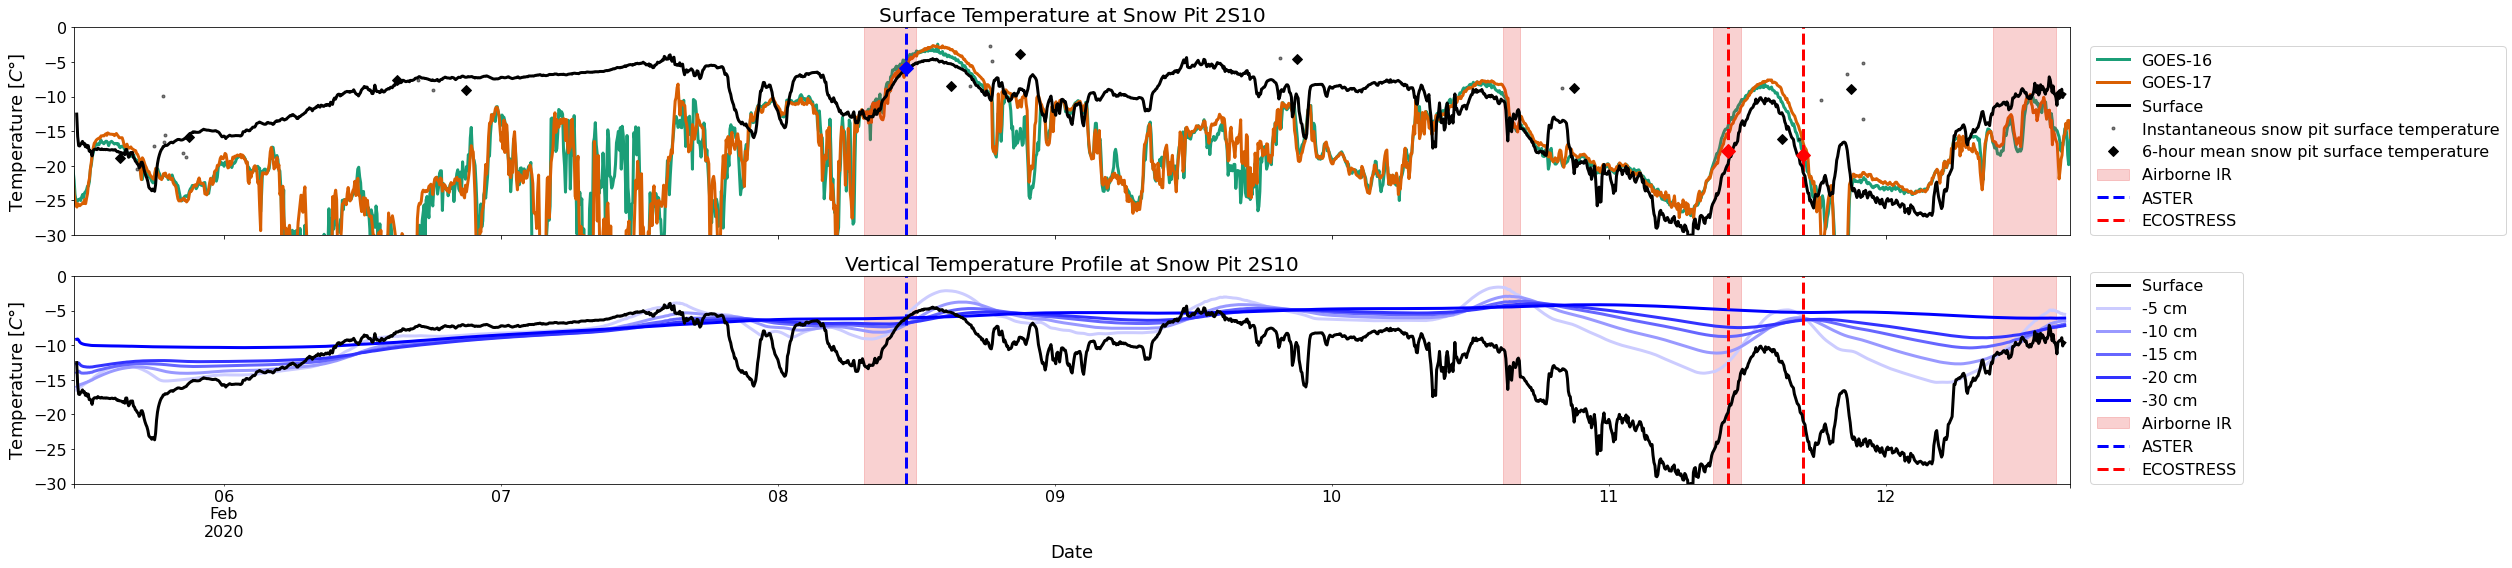

In [32]:
fig, [ax, ax2] = plt.subplots(2,1,figsize=(35,8), tight_layout=True)


startdate = pd.datetime(2020,2,5,11,0)
enddate = pd.datetime(2020,2,12,16,0)

airborne_color = '#e41a1c'
eco_color = 'red'
ast_color = 'blue'
g16_color = '#1b9e77'
g17_color = '#d95f02'
    
# Plot surface temperature and remotely sensed temps
g16_c14.tb.plot(ax=ax, linestyle='-', linewidth=3, c=g16_color, label='GOES-16', zorder=-0)
g17_c14.tb.plot(ax=ax, linestyle='-', linewidth=3,  c=g17_color, label='GOES-17', zorder=0)
gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=3,  c='k', label='Surface', zorder=99)
# ASTER Mean Brightness Temp at Snow Pit 2S10 = -5.8 C
ax.plot(pd.datetime(2020,2,8,11,7),-5.8,'D',c=ast_color,markersize=10, zorder=99)
# ECOSTRESS Mean Brightness Temp at Snow Pit 2S10 = -17.9, -18.4 C
ax.plot(pd.datetime(2020,2,11,10,22),-17.9,'D',c=eco_color,markersize=10, zorder=99)
ax.plot(pd.datetime(2020,2,11,16,52),-18.4,'D',c=eco_color,markersize=10, zorder=99)
ax.set_ylim((-30,0))
ax.set_xlim((startdate,enddate))
ax.set_ylabel('Temperature [$C\degree$]')
#ax.set_xlabel('Time')
ax.set_title('Surface Temperature at Snow Pit 2S10');

# plot snow pit temperatures
df_tss.temperature.plot(linestyle='none',marker='.', color='k', alpha=0.5, ax=ax, label='Instantaneous snow pit surface temperature')
df_tss.resample('6H', loffset='3H').mean().temperature.plot(linestyle='none', marker='D', markersize=7, color='k', ax=ax, label='6-hour mean snow pit surface temperature')



# Plot vertical snow temperature profile
gm1.rad_avg.plot(ax=ax2, linestyle='-', linewidth=3, c='k', label='Surface', zorder=99)
gm1.temp1_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0.8,0.8,1], label='-5 cm')
gm1.temp2_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0.6,0.6,1], label='-10 cm')
gm1.temp3_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0.4,0.4,1], label='-15 cm')
gm1.temp4_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0.2,0.2,1], label='-20 cm')
gm1.temp5_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0,0,1], label='-30 cm')

ax2.set_ylim((-30,0))
ax2.set_xlim((startdate,enddate))
ax2.set_ylabel('Temperature [$C\degree$]')
ax2.set_xlabel('Date')
ax2.set_title('Vertical Temperature Profile at Snow Pit 2S10')



# add vertical lines for the aircraft flight datetimes, satellite pass datetimes
for each_ax in [ax, ax2]:
    
    # Airborne IR, Feb 8th
    each_ax.fill_between([pd.datetime(2020, 2, 8, 7, 28), pd.datetime(2020, 2, 8, 11, 56)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2, label='Airborne IR')
    # Airborne IR, Feb 10th
    each_ax.fill_between([pd.datetime(2020, 2, 10, 14, 52), pd.datetime(2020, 2, 10, 16, 18)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    # Airborne IR, Feb 11th
    each_ax.fill_between([pd.datetime(2020, 2, 11, 9, 1), pd.datetime(2020, 2, 11, 11, 26)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    # Airborne IR, Feb 12th
    each_ax.fill_between([pd.datetime(2020, 2, 12, 9, 19), pd.datetime(2020, 2, 12, 14, 47)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    
    # ASTER
    each_ax.axvline(pd.datetime(2020,2,8,11,7), linestyle='--', color=ast_color, linewidth='3', label='ASTER')
    
    # ECOSTRESS
    each_ax.axvline(pd.datetime(2020,2,11,10,22), linestyle='--', color=eco_color, linewidth='3', label='ECOSTRESS')
    each_ax.axvline(pd.datetime(2020,2,11,16,52), linestyle='--', color=eco_color, linewidth='3')

    
# add legends
ax.legend(loc=(1.01,0))
ax2.legend(loc=(1.01,0))
 
fig.autofmt_xdate() 





## GM 1
#times1 = gm1.index
#depths1 = np.array([0, 5, 10, 15, 20, 30])
#temp_data = np.array([gm1.rad_avg, gm1.temp1_avg, gm1.temp2_avg, gm1.temp3_avg, gm1.temp4_avg, gm1.temp5_avg])
#gm1_snow_temp = xr.DataArray(temp_data, coords=[depths1, times1], dims=['depth', 'time'])
#gm1_snow_temp.plot(ax=ax2, cmap='magma', vmin=-30, vmax=0,
#                  cbar_kwargs={'label':'Temperature [$C\degree$]'})
#ax2.set_xlim((startdate,enddate))
#ax2.set_ylim((30,0))
#ax2.set_xlabel('Time')
#ax2.set_ylabel('Depth [cm]')
#ax2.set_title('Vertical Temperature Profile at Snow Pit 2S10')
#
#


plt.savefig('timeline_new_colors.jpg',dpi=300)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_

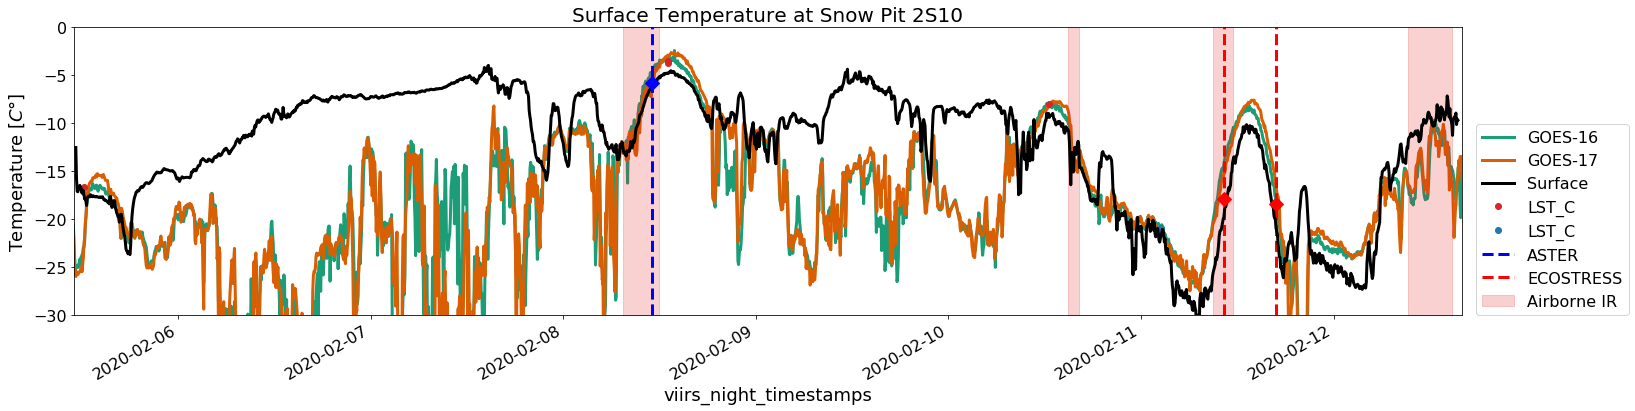

In [18]:
fig, ax = plt.subplots(1,1,figsize=(23,6), tight_layout=True)


startdate = pd.datetime(2020,2,5,11,0)
enddate = pd.datetime(2020,2,12,16,0)

airborne_color = '#e41a1c'
eco_color = 'red'
ast_color = 'blue'
g16_color = '#1b9e77'
g17_color = '#d95f02'
    
# Plot surface temperature and remotely sensed temps
g16_c14.tb.plot(ax=ax, linestyle='-', linewidth=3, c=g16_color, label='GOES-16', zorder=-0)
g17_c14.tb.plot(ax=ax, linestyle='-', linewidth=3,  c=g17_color, label='GOES-17', zorder=0)
gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=3,  c='k', label='Surface', zorder=99)
# ASTER Mean Brightness Temp at Snow Pit 2S10 = -5.8 C
ax.plot(pd.datetime(2020,2,8,11,7),-5.8,'D',c=ast_color,markersize=10, zorder=99)
# ECOSTRESS Mean Brightness Temp at Snow Pit 2S10 = -17.9, -18.4 C
ax.plot(pd.datetime(2020,2,11,10,22),-17.9,'D',c=eco_color,markersize=10, zorder=99)
ax.plot(pd.datetime(2020,2,11,16,52),-18.4,'D',c=eco_color,markersize=10, zorder=99)




viirs_day.plot(x='viirs_day_timestamps', y='LST_C', linestyle='none', marker='o', color='tab:red', ax=ax)
viirs_night.plot(x='viirs_night_timestamps', y='LST_C', linestyle='none', marker='o', color='tab:blue', ax=ax)






ax.set_ylim((-30,0))
ax.set_xlim((startdate,enddate))
ax.set_ylabel('Temperature [$C\degree$]')
#ax.set_xlabel('Time')
ax.set_title('Surface Temperature at Snow Pit 2S10');




# add vertical lines for the aircraft flight datetimes, satellite pass datetimes
for each_ax in [ax]:
    
    # Airborne IR, Feb 8th
    each_ax.fill_between([pd.datetime(2020, 2, 8, 7, 28), pd.datetime(2020, 2, 8, 11, 56)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2, label='Airborne IR')
    # Airborne IR, Feb 10th
    each_ax.fill_between([pd.datetime(2020, 2, 10, 14, 52), pd.datetime(2020, 2, 10, 16, 18)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    # Airborne IR, Feb 11th
    each_ax.fill_between([pd.datetime(2020, 2, 11, 9, 1), pd.datetime(2020, 2, 11, 11, 26)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    # Airborne IR, Feb 12th
    each_ax.fill_between([pd.datetime(2020, 2, 12, 9, 19), pd.datetime(2020, 2, 12, 14, 47)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    
    # ASTER
    each_ax.axvline(pd.datetime(2020,2,8,11,7), linestyle='--', color=ast_color, linewidth='3', label='ASTER')
    
    # ECOSTRESS
    each_ax.axvline(pd.datetime(2020,2,11,10,22), linestyle='--', color=eco_color, linewidth='3', label='ECOSTRESS')
    each_ax.axvline(pd.datetime(2020,2,11,16,52), linestyle='--', color=eco_color, linewidth='3')

    
# add legends
ax.legend(loc=(1.01,0))

 
fig.autofmt_xdate() 





## GM 1
#times1 = gm1.index
#depths1 = np.array([0, 5, 10, 15, 20, 30])
#temp_data = np.array([gm1.rad_avg, gm1.temp1_avg, gm1.temp2_avg, gm1.temp3_avg, gm1.temp4_avg, gm1.temp5_avg])
#gm1_snow_temp = xr.DataArray(temp_data, coords=[depths1, times1], dims=['depth', 'time'])
#gm1_snow_temp.plot(ax=ax2, cmap='magma', vmin=-30, vmax=0,
#                  cbar_kwargs={'label':'Temperature [$C\degree$]'})
#ax2.set_xlim((startdate,enddate))
#ax2.set_ylim((30,0))
#ax2.set_xlabel('Time')
#ax2.set_ylabel('Depth [cm]')
#ax2.set_title('Vertical Temperature Profile at Snow Pit 2S10')
#
#


plt.savefig('timeline_new_colors2.jpg',dpi=300)

---

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


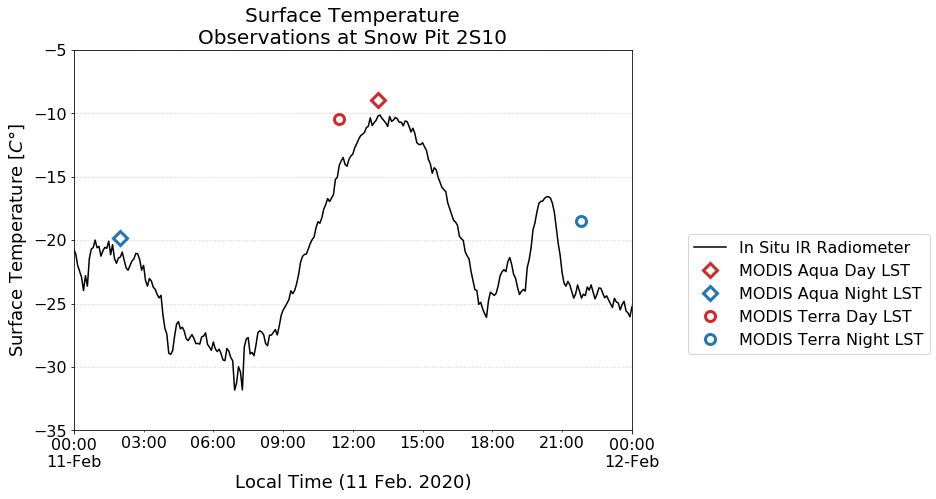

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,7))

# only look where there's few clouds
startdate = pd.datetime(2020,2,11)
enddate = pd.datetime(2020,2,12)

#g16_c14.tb.plot(ax=ax, linestyle='-', marker='', markersize=5, c='#1b9e77', label='GOES-16 11.2$\mu m$', zorder=99)
#g17_c14.tb.plot(ax=ax, linestyle='-', marker='', markersize=5, c='#d95f02', label='GOES-17 11.2$\mu m$', zorder=99)
#
#g16_c7.tb.plot(ax=ax, linestyle=':', marker='', markersize=5, c='#1b9e77', label='GOES-16 3.9$\mu m$', zorder=99)
#g17_c7.tb.plot(ax=ax, linestyle=':', marker='', markersize=5, c='#d95f02', label='GOES-17 3.9$\mu m$', zorder=99)

gm1.rad_avg.plot(ax=ax, linestyle='-', marker='', markersize=0, c='k', label='In Situ IR Radiometer', zorder=99)

# ECOSTRESS Mean LST at Snow Pit 2S10 = -17.9, -18.4 C
#ax.plot(pd.datetime(2020,2,11,10,22),-17.9,'D',c=eco_color,markersize=10, zorder=99, label='ECOSTRESS LST')
#ax.plot(pd.datetime(2020,2,11,16,52),-18.4,'D',c=eco_color,markersize=10, zorder=99)
# ASTER Mean Brightness Temp at Snow Pit 2S10 = -5.8 C
#ax.plot(pd.datetime(2020,2,8,11,7),-5.8,'D',c='blue',markersize=10, zorder=99, label='ASTER 11.3$\mu m$')
#diff_aster = -5.8 - gm1.rad_avg[pd.datetime(2020,2,8,11,5)]
#print('diff_aster:', diff_aster)

#viirs_day[viirs_day.ID == 'pit2s10'].plot(x='viirs_day_timestamps', y='LST_C', linestyle='none', markersize=10, marker='s', color='tab:red', ax=ax, label='SNPP VIIRS LST')
#viirs_night.plot(x='viirs_night_timestamps', y='LST_C', linestyle='none', marker='o', color='tab:blue', ax=ax)

modis_aqua[modis_aqua.ID == 'pit2s10'].plot(x='modis_aqua_day_timestamps', y='LST_Day_C', linestyle='none', markersize=10, marker='D', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:red', ax=ax, label='MODIS Aqua Day LST')
modis_aqua[modis_aqua.ID == 'pit2s10'].plot(x='modis_aqua_night_timestamps', y='LST_Night_C', linestyle='none', markersize=10, marker='D', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:blue', ax=ax, label='MODIS Aqua Night LST')

modis_terra[modis_terra.ID == 'pit2s10'].plot(x='modis_terra_day_timestamps', y='LST_Day_C', linestyle='none', markersize=10, marker='o', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:red', ax=ax, label='MODIS Terra Day LST')
modis_terra[modis_terra.ID == 'pit2s10'].plot(x='modis_terra_night_timestamps', y='LST_Night_C', linestyle='none', markersize=10, marker='o', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:blue', ax=ax, label='MODIS Terra Night LST')

ax.set_ylim((-35,-5))
ax.set_xlim((startdate,enddate))

ax.legend(loc=(1.1,0.2))
ax.set_ylabel('Surface Temperature [$C\degree$]')
ax.set_xlabel('Local Time (11 Feb. 2020)')
ax.set_title('Surface Temperature\nObservations at Snow Pit 2S10');
ax.grid(color='lightgrey', linestyle=':', linewidth=1)






In [44]:
modis_terra = modis_terra[modis_terra.ID == 'pit2s10']
modis_aqua = modis_aqua[modis_aqua.ID == 'pit2s10']

In [59]:
gm1.rad_avg[pd.datetime(2020,2,11,11,25)]

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


-14.097999999999999

In [58]:
gm1.rad_avg[pd.datetime(2020,2,8,11,25)]

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


-14.097999999999999

In [47]:
modis_terra

,Category,ID,Latitude,Longitude,Date,MODIS_Tile,MOD11A1_006_Line_Y_1km,MOD11A1_006_Sample_X_1km,MOD11A1_006_Clear_day_cov,MOD11A1_006_Clear_night_cov,...,MOD11A1_006_QC_Night_Data_Quality_flag,MOD11A1_006_QC_Night_Data_Quality_flag_Description,MOD11A1_006_QC_Night_Emis_Error_flag,MOD11A1_006_QC_Night_Emis_Error_flag_Description,MOD11A1_006_QC_Night_LST_Error_Flag,MOD11A1_006_QC_Night_LST_Error_Flag_Description,modis_terra_day_timestamps,modis_terra_night_timestamps,LST_Day_C,LST_Night_C
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-02,grandmesa,pit2s10,39.0195,-108.1923,2020-02-02,h09v05,117,713,1.0000,1.0000,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-02 11:30:00,2020-02-02 21:54:00,-1.19,-16.55
2020-02-11,grandmesa,pit2s10,39.0195,-108.1923,2020-02-11,h09v05,117,713,1.2995,0.3210,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b01,Average LST error <= 2K,2020-02-11 11:24:00,2020-02-11 21:48:00,-10.43,-18.53
2020-02-20,grandmesa,pit2s10,39.0195,-108.1923,2020-02-20,h09v05,117,713,1.0000,0.1545,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-20 11:18:00,2020-02-20 21:42:00,-8.67,-20.49
2020-02-21,grandmesa,pit2s10,39.0195,-108.1923,2020-02-21,h09v05,117,713,1.0000,0.9945,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b01,Average LST error <= 2K,2020-02-21 10:24:00,2020-02-21 22:24:00,-3.33,-23.59
2020-02-24,grandmesa,pit2s10,39.0195,-108.1923,2020-02-24,h09v05,117,713,0.9765,1.0000,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b01,Average LST error <= 2K,2020-02-24 10:54:00,2020-02-24 22:54:00,-9.21,-13.51
2020-02-25,grandmesa,pit2s10,39.0195,-108.1923,2020-02-25,h09v05,117,713,0.2885,1.0000,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b01,Average LST error <= 2K,2020-02-25 11:36:00,2020-02-25 22:00:00,-12.15,-19.83
2020-02-27,grandmesa,pit2s10,39.0195,-108.1923,2020-02-27,h09v05,117,713,1.0000,0.0485,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b01,Average LST error <= 2K,2020-02-27 11:24:00,2020-02-27 21:48:00,-4.21,-17.43
2020-02-28,grandmesa,pit2s10,39.0195,-108.1923,2020-02-28,h09v05,117,713,1.9895,1.0000,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-28 10:30:00,2020-02-28 22:30:00,-3.53,-17.69


In [71]:
print('\n modis terra bias day Feb 11')
print(-10.43 - gm1.rad_avg[pd.datetime(2020,2,11,11,25)])

print('\n modis terra bias night Feb 11')
print(-18.53 - gm1.rad_avg[pd.datetime(2020,2,11,21,50)])

print('\n terra mean bias')
print(np.mean(np.array([-10.43 - gm1.rad_avg[pd.datetime(2020,2,11,11,25)] , -18.53 - gm1.rad_avg[pd.datetime(2020,2,11,21,50)]])))

print('\n modis aqua bias day Feb 11')
print(-8.99 - gm1.rad_avg[pd.datetime(2020,2,11,13,5)])

print('\n modis aqua bias night Feb 11')
print(-19.83 - gm1.rad_avg[pd.datetime(2020,2,11,2,0)])

print('\n aqua mean bias')
print(np.mean(np.array([-8.99 - gm1.rad_avg[pd.datetime(2020,2,11,13,5)] , -19.83 - gm1.rad_avg[pd.datetime(2020,2,11,2,0)]])))

print('\n day mean bias')
print(np.mean(np.array([-8.99 - gm1.rad_avg[pd.datetime(2020,2,11,13,5)] , -10.43 - gm1.rad_avg[pd.datetime(2020,2,11,11,25)]])))

print('\n night mean bias')
print(np.mean(np.array([-19.83 - gm1.rad_avg[pd.datetime(2020,2,11,2,0)] , -18.53 - gm1.rad_avg[pd.datetime(2020,2,11,21,50)]])))

print('\n MODIS mean bias')
print(np.mean(np.array([-8.99 - gm1.rad_avg[pd.datetime(2020,2,11,13,5)] , 
                        -19.83 - gm1.rad_avg[pd.datetime(2020,2,11,2,0)],
                        -10.43 - gm1.rad_avg[pd.datetime(2020,2,11,11,25)] ,
                        -18.53 - gm1.rad_avg[pd.datetime(2020,2,11,21,50)]])))



 modis terra bias day Feb 11
3.6679999999999993

 modis terra bias night Feb 11
6.035999999999998

 terra mean bias
4.8519999999999985

 modis aqua bias day Feb 11
1.218

 modis aqua bias night Feb 11
1.5030000000000037

 aqua mean bias
1.3605000000000018

 day mean bias
2.4429999999999996

 night mean bias
3.7695000000000007

 MODIS mean bias
3.10625


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\steve\Anaconda3\envs\rasterenv\lib\s

1.218
1.5030000000000037
1.3605000000000018


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [48]:
modis_aqua

,Category,ID,Latitude,Longitude,Date,MODIS_Tile,MYD11A1_006_Line_Y_1km,MYD11A1_006_Sample_X_1km,MYD11A1_006_Clear_day_cov,MYD11A1_006_Clear_night_cov,...,MYD11A1_006_QC_Night_Data_Quality_flag,MYD11A1_006_QC_Night_Data_Quality_flag_Description,MYD11A1_006_QC_Night_Emis_Error_flag,MYD11A1_006_QC_Night_Emis_Error_flag_Description,MYD11A1_006_QC_Night_LST_Error_Flag,MYD11A1_006_QC_Night_LST_Error_Flag_Description,modis_aqua_day_timestamps,modis_aqua_night_timestamps,LST_Day_C,LST_Night_C
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-02,grandmesa,pit2s10,39.0195,-108.1923,2020-02-02,h09v05,117,713,1.0000,1.0000,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-02 13:12:00,2020-02-02 02:06:00,-2.77,-17.15
2020-02-11,grandmesa,pit2s10,39.0195,-108.1923,2020-02-11,h09v05,117,713,1.0000,1.0000,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-11 13:06:00,2020-02-11 02:00:00,-8.99,-19.83
2020-02-14,grandmesa,pit2s10,39.0195,-108.1923,2020-02-14,h09v05,117,713,1.0000,1.0000,...,0b10,TBD,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-14 13:36:00,2020-02-14 02:30:00,-3.69,-15.43
2020-02-17,grandmesa,pit2s10,39.0195,-108.1923,2020-02-17,h09v05,117,713,0.0925,1.2160,...,0b10,TBD,0b00,Average emissivity error <= 0.01,0b01,Average LST error <= 2K,2020-02-17 12:30:00,2020-02-17 01:24:00,-8.11,-11.67
2020-02-18,grandmesa,pit2s10,39.0195,-108.1923,2020-02-18,h09v05,117,713,1.0000,0.4595,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b01,Average LST error <= 2K,2020-02-18 13:12:00,2020-02-18 02:06:00,-8.11,-16.99
2020-02-20,grandmesa,pit2s10,39.0195,-108.1923,2020-02-20,h09v05,117,713,1.0000,0.9975,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-20 13:00:00,2020-02-20 01:54:00,-6.05,-26.31
2020-02-21,grandmesa,pit2s10,39.0195,-108.1923,2020-02-21,h09v05,117,713,2.0000,1.0000,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-21 13:42:00,2020-02-21 02:36:00,-0.75,-16.37
2020-02-25,grandmesa,pit2s10,39.0195,-108.1923,2020-02-25,h09v05,117,713,0.8155,0.5185,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b01,Average LST error <= 2K,2020-02-25 13:18:00,2020-02-25 02:12:00,-12.31,-16.59
2020-02-27,grandmesa,pit2s10,39.0195,-108.1923,2020-02-27,h09v05,117,713,1.0000,1.0000,...,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K,2020-02-27 13:06:00,2020-02-27 02:00:00,-3.57,-18.47


In [31]:
modis_aqua[modis_aqua.ID == 'pit2s10'].plot(x='modis_aqua_day_timestamps', y='LST_Day_C', linestyle='none', markersize=10, marker='D', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:red', ax=ax, label='MODIS Aqua Day LST')
modis_aqua[modis_aqua.ID == 'pit2s10'].plot(x='modis_aqua_night_timestamps', y='LST_Night_C', linestyle='none', markersize=10, marker='D', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:blue', ax=ax, label='MODIS Aqua Night LST')

modis_terra[modis_terra.ID == 'pit2s10'].plot(x='modis_terra_day_timestamps', y='LST_Day_C', linestyle='none', markersize=10, marker='o', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:red', ax=ax, label='MODIS Terra Day LST')
modis_terra[modis_terra.ID == 'pit2s10'].plot(x='modis_terra_night_timestamps', y='LST_Night_C', linestyle='none', markersize=10, marker='o', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:blue', ax=ax, label='MODIS Terra Night LST')



diff_g17 = g17_c14.tb[startdate:enddate] - gm1.rad_avg[startdate:enddate][:-1].values

Zoomed in with more GOES bands

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime i

diff_aster: 0.3523000000000005
1.1401206083550552 1.5233471244137504
0.960377248683121 1.242596676030593


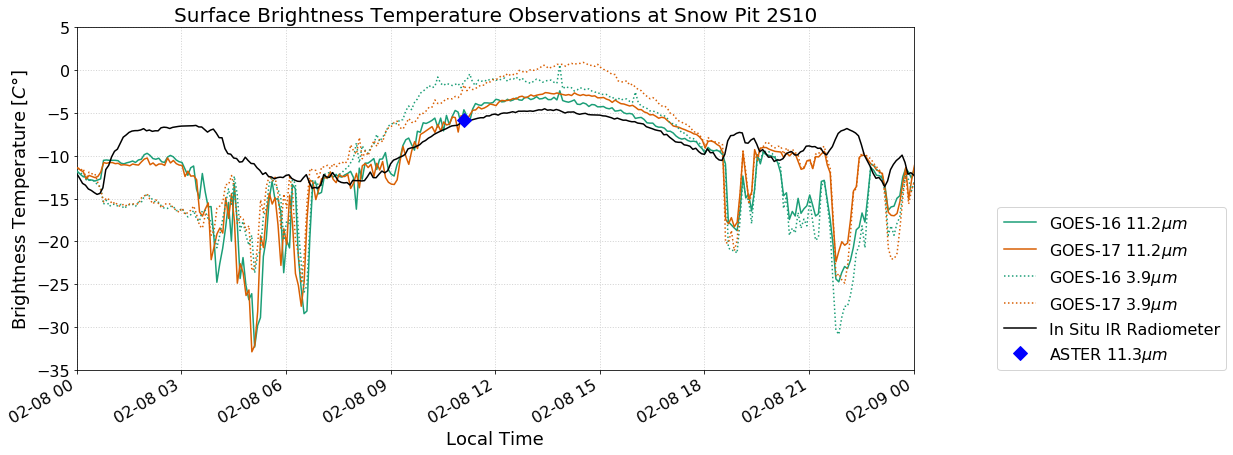

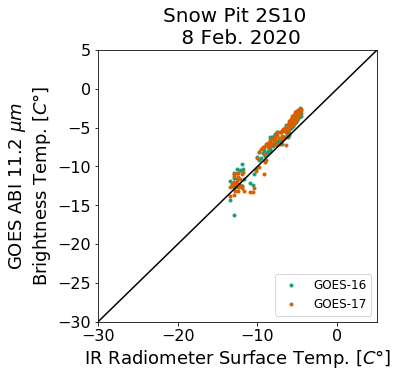

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

startdate = pd.datetime(2020,2,8)
enddate = pd.datetime(2020,2,9)

g16_c14.tb.plot(ax=ax, linestyle='-', marker='', markersize=5, c='#1b9e77', label='GOES-16 11.2$\mu m$', zorder=99)
g17_c14.tb.plot(ax=ax, linestyle='-', marker='', markersize=5, c='#d95f02', label='GOES-17 11.2$\mu m$', zorder=99)

g16_c7.tb.plot(ax=ax, linestyle=':', marker='', markersize=5, c='#1b9e77', label='GOES-16 3.9$\mu m$', zorder=99)
g17_c7.tb.plot(ax=ax, linestyle=':', marker='', markersize=5, c='#d95f02', label='GOES-17 3.9$\mu m$', zorder=99)

gm1.rad_avg.plot(ax=ax, linestyle='-', marker='', markersize=0, c='k', label='In Situ IR Radiometer', zorder=99)

# ECOSTRESS Mean LST at Snow Pit 2S10 = -17.9, -18.4 C
#ax.plot(pd.datetime(2020,2,11,10,22),-17.9,'D',c=eco_color,markersize=10, zorder=99, label='ECOSTRESS LST')
#ax.plot(pd.datetime(2020,2,11,16,52),-18.4,'D',c=eco_color,markersize=10, zorder=99)
# ASTER Mean Brightness Temp at Snow Pit 2S10 = -5.8 C
ax.plot(pd.datetime(2020,2,8,11,7),-5.8,'D',c='blue',markersize=10, zorder=99, label='ASTER 11.3$\mu m$')
diff_aster = -5.8 - gm1.rad_avg[pd.datetime(2020,2,8,11,5)]
print('diff_aster:', diff_aster)

ax.set_ylim((-35,5))
ax.set_xlim((startdate,enddate))

ax.legend(loc=(1.1,0))
ax.set_ylabel('Brightness Temperature [$C\degree$]')
ax.set_xlabel('Local Time')
ax.set_title('Surface Brightness Temperature Observations at Snow Pit 2S10');
ax.grid(color='lightgrey', linestyle=':', linewidth=1)




######

# only look where there's no clouds
startdate = pd.datetime(2020,2,8,7)
enddate = pd.datetime(2020,2,8,18)

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot( gm1.rad_avg[startdate:enddate][:-1].values, g16_c14.tb[startdate:enddate],
        linestyle='none', marker='.', color='#1b9e77', label='GOES-16')

ax.plot( gm1.rad_avg[startdate:enddate][:-1].values, g17_c14.tb[startdate:enddate],
        linestyle='none', marker='.', color='#d95f02', label='GOES-17')

ax.plot([-30, 5], [-30, 5], '-k')

ax.set_xlim(-30,5)
ax.set_ylim(-30,5)

ax.set_xlabel('IR Radiometer Surface Temp. [$C\degree$]')
ax.set_ylabel('GOES ABI 11.2 $\mu m$\nBrightness Temp. [$C\degree$]')

ax.legend(fontsize=12, loc='lower right')

ax.set_title('Snow Pit 2S10 \n 8 Feb. 2020')



######



diff_g17 = g17_c14.tb[startdate:enddate] - gm1.rad_avg[startdate:enddate][:-1].values
mean_bias_g17 = np.mean( diff_g17 )
rmse_g17 = np.sqrt( np.mean( diff_g17**2 ) )
print(mean_bias_g17, rmse_g17)

diff_g16 = g16_c14.tb[startdate:enddate] - gm1.rad_avg[startdate:enddate][:-1].values
mean_bias_g16 = np.mean( diff_g16 )
rmse_g16 = np.sqrt( np.mean( diff_g16**2 ) )
print(mean_bias_g16, rmse_g16)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


2.910699783279777 3.305004703660968
2.7036973683009635 3.2456384587756792


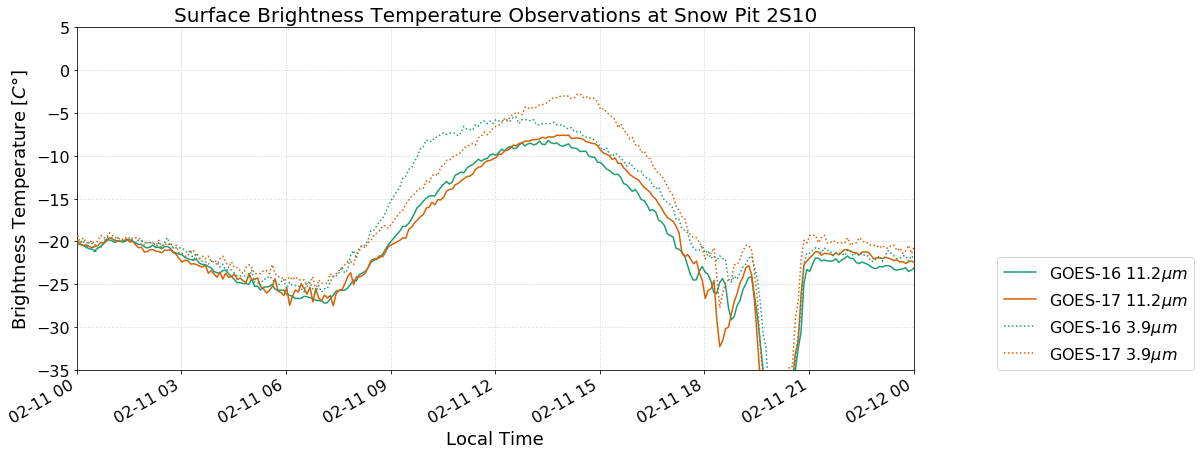

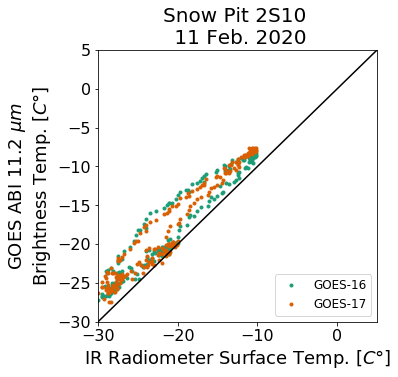

In [28]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

startdate = pd.datetime(2020,2,11)
enddate = pd.datetime(2020,2,12)

g16_c14.tb.plot(ax=ax, linestyle='-', marker='', markersize=5, c='#1b9e77', label='GOES-16 11.2$\mu m$', zorder=99)
g17_c14.tb.plot(ax=ax, linestyle='-', marker='', markersize=5, c='#d95f02', label='GOES-17 11.2$\mu m$', zorder=99)

g16_c7.tb.plot(ax=ax, linestyle=':', marker='', markersize=5, c='#1b9e77', label='GOES-16 3.9$\mu m$', zorder=99)
g17_c7.tb.plot(ax=ax, linestyle=':', marker='', markersize=5, c='#d95f02', label='GOES-17 3.9$\mu m$', zorder=99)

#gm1.rad_avg.plot(ax=ax, linestyle='-', marker='', markersize=0, c='k', label='In Situ IR Radiometer', zorder=99)
#
## ECOSTRESS Mean LST at Snow Pit 2S10 = -17.9, -18.4 C
#ax.plot(pd.datetime(2020,2,11,10,22),-17.9,'D',c=eco_color,markersize=10, zorder=99, label='ECOSTRESS LST')
#ax.plot(pd.datetime(2020,2,11,16,52),-18.4,'D',c=eco_color,markersize=10, zorder=99)
#diff_eco_am = -17.9 - gm1.rad_avg[pd.datetime(2020,2,11,10,20)]
#print('diff_eco_am:', diff_eco_am)
#diff_eco_pm = -18.4 - gm1.rad_avg[pd.datetime(2020,2,11,16,50)]
#print('diff_eco_pm:', diff_eco_pm)
## ASTER Mean Brightness Temp at Snow Pit 2S10 = -5.8 C
##ax.plot(pd.datetime(2020,2,8,11,7),-5.8,'D',c='blue',markersize=10, zorder=99, label='ASTER 11.3$\mu m$')
#
#
#modis_aqua[modis_aqua.ID == 'pit2s10'].plot(x='modis_aqua_day_timestamps', y='LST_Day_C', linestyle='none', markersize=10, marker='D', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:red', ax=ax, label='MODIS Aqua Day LST')
#modis_aqua[modis_aqua.ID == 'pit2s10'].plot(x='modis_aqua_night_timestamps', y='LST_Night_C', linestyle='none', markersize=10, marker='D', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:blue', ax=ax, label='MODIS Aqua Night LST')
#
#modis_terra[modis_terra.ID == 'pit2s10'].plot(x='modis_terra_day_timestamps', y='LST_Day_C', linestyle='none', markersize=10, marker='o', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:red', ax=ax, label='MODIS Terra Day LST')
#modis_terra[modis_terra.ID == 'pit2s10'].plot(x='modis_terra_night_timestamps', y='LST_Night_C', linestyle='none', markersize=10, marker='o', markeredgewidth=3, markerfacecolor='white', markeredgecolor='tab:blue', ax=ax, label='MODIS Terra Night LST')


ax.set_ylim((-35,5))
ax.set_xlim((startdate,enddate))

ax.legend(loc=(1.1,0))
ax.set_ylabel('Brightness Temperature [$C\degree$]')
ax.set_xlabel('Local Time')
ax.set_title('Surface Brightness Temperature Observations at Snow Pit 2S10');
ax.grid(color='lightgrey', linestyle=':', linewidth=1)




######

# stop before cloud cover
enddate = pd.datetime(2020,2,11,18)

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot( gm1.rad_avg[startdate:enddate][:-3].values, g16_c14.tb[startdate:enddate],
        linestyle='none', marker='.', color='#1b9e77', label='GOES-16')

ax.plot( gm1.rad_avg[startdate:enddate][:-4].values, g17_c14.tb[startdate:enddate],
        linestyle='none', marker='.', color='#d95f02', label='GOES-17')

ax.plot([-30, 5], [-30, 5], '-k')

ax.set_xlim(-30,5)
ax.set_ylim(-30,5)

ax.set_xlabel('IR Radiometer Surface Temp. [$C\degree$]')
ax.set_ylabel('GOES ABI 11.2 $\mu m$\nBrightness Temp. [$C\degree$]')

ax.legend(fontsize=12, loc='lower right')

ax.set_title('Snow Pit 2S10 \n 11 Feb. 2020')



######



diff_g17 = g17_c14.tb[startdate:enddate] - gm1.rad_avg[startdate:enddate][:-4].values
mean_bias_g17 = np.mean( diff_g17 )
rmse_g17 = np.sqrt( np.mean( diff_g17**2 ) )
print(mean_bias_g17, rmse_g17)

diff_g16 = g16_c14.tb[startdate:enddate] - gm1.rad_avg[startdate:enddate][:-3].values
mean_bias_g16 = np.mean( diff_g16 )
rmse_g16 = np.sqrt( np.mean( diff_g16**2 ) )
print(mean_bias_g16, rmse_g16)


Another plot zoomed in

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


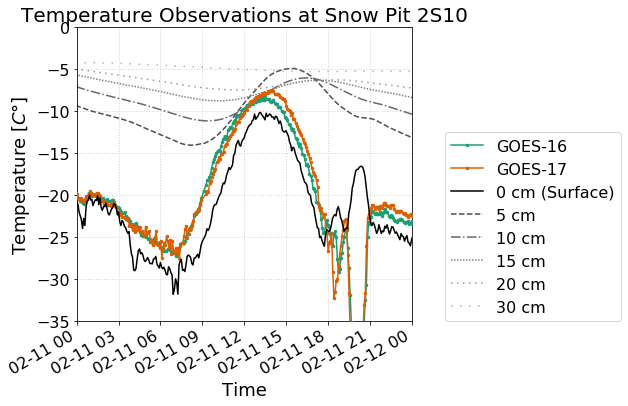

In [30]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

startdate = pd.datetime(2020,2,11)
enddate = pd.datetime(2020,2,12)

g16_c14.tb.plot(ax=ax, linestyle='-', marker='.', markersize=5, c='#1b9e77', label='GOES-16', zorder=99)
g17_c14.tb.plot(ax=ax, linestyle='-', marker='.', markersize=5, c='#d95f02', label='GOES-17', zorder=99)

gm1.rad_avg.plot(ax=ax, linestyle='-', marker='.', markersize=0, c='k', label='0 cm (Surface)', zorder=99)

gm1.temp1_avg.plot(ax=ax, linestyle='--', marker='.', markersize=0, c=[0.3,0.3,0.3], label='5 cm')
gm1.temp2_avg.plot(ax=ax, linestyle='-.', marker='.', markersize=0, c=[0.4,0.4,0.4], label='10 cm')
gm1.temp3_avg.plot(ax=ax, linestyle=(0, (1,1)), marker='.', markersize=0, c=[0.5,0.5,0.5], label='15 cm')
gm1.temp4_avg.plot(ax=ax, linestyle=(0, (1,3)), marker='.', markersize=0, c=[0.6,0.6,0.6], label='20 cm')
gm1.temp5_avg.plot(ax=ax, linestyle=(0, (1,5)), marker='.', markersize=0, c=[0.7,0.7,0.7], label='30 cm')


ax.set_ylim((-35,0))
ax.set_xlim((startdate,enddate))

ax.legend(loc=(1.1,0))
ax.set_ylabel('Temperature [$C\degree$]')
ax.set_xlabel('Time')
ax.set_title('Temperature Observations at Snow Pit 2S10');
ax.grid(color='lightgrey', linestyle=':', linewidth=1)